In [2]:
from functools import partial

from seals import base_envs
from seals.diagnostics.cliff_world import CliffWorldEnv
from stable_baselines3.common.vec_env import DummyVecEnv

import numpy as np

from imitation.algorithms.mce_irl import (
    MCEIRL,
    mce_occupancy_measures,
    mce_partition_fh,
    TabularPolicy,
)
from imitation.data import rollout
from imitation.rewards import reward_nets

env_creator = partial(CliffWorldEnv, height=4, horizon=8, width=7, use_xy_obs=True)
env_single = env_creator()

state_env_creator = lambda: base_envs.ExposePOMDPStateWrapper(env_creator())

# This is just a vectorized environment because `generate_trajectories` expects one
state_venv = DummyVecEnv([state_env_creator] * 4)

In [3]:
_, _, pi = mce_partition_fh(env_single)

_, om = mce_occupancy_measures(env_single, pi=pi)

rng = np.random.default_rng()
expert = TabularPolicy(
    state_space=env_single.state_space,
    action_space=env_single.action_space,
    pi=pi,
    rng=rng,
)

expert_trajs = rollout.generate_trajectories(
    policy=expert,
    venv=state_venv,
    sample_until=rollout.make_min_timesteps(5000),
    rng=rng,
)

print("Expert stats: ", rollout.rollout_stats(expert_trajs))

Expert stats:  {'n_traj': 628, 'return_min': -24.0, 'return_mean': 5.872611464968153, 'return_std': 8.38597260264739, 'return_max': 14.0, 'len_min': 8, 'len_mean': 8.0, 'len_std': 0.0, 'len_max': 8}


In [4]:
import matplotlib.pyplot as plt
import torch as th


def train_mce_irl(demos, hidden_sizes, lr=0.01, **kwargs):
    reward_net = reward_nets.BasicRewardNet(
        env_single.observation_space,
        env_single.action_space,
        hid_sizes=hidden_sizes,
        use_action=False,
        use_done=False,
        use_next_state=False,
    )

    mce_irl = MCEIRL(
        demos,
        env_single,
        reward_net,
        log_interval=250,
        optimizer_kwargs=dict(lr=lr),
        rng=rng,
    )
    occ_measure = mce_irl.train(**kwargs)

    imitation_trajs = rollout.generate_trajectories(
        policy=mce_irl.policy,
        venv=state_venv,
        sample_until=rollout.make_min_timesteps(5000),
        rng=rng,
    )
    print("Imitation stats: ", rollout.rollout_stats(imitation_trajs))

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(occ_measure)
    plt.title("Occupancy for learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    _, true_occ_measure = mce_occupancy_measures(env_single)
    env_single.draw_value_vec(true_occ_measure)
    plt.title("Occupancy for true reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    env_single.draw_value_vec(
        reward_net(th.as_tensor(env_single.observation_matrix), None, None, None)
        .detach()
        .numpy()
    )
    plt.title("Learned reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.subplot(1, 2, 2)
    env_single.draw_value_vec(env_single.reward_matrix)
    plt.title("True reward")
    plt.xlabel("Gridworld x-coordinate")
    plt.ylabel("Gridworld y-coordinate")
    plt.show()

    return mce_irl

--------------------------
| grad_norm   | 3.58     |
| iteration   | 0        |
| linf_delta  | 2.03     |
| weight_norm | 0.598    |
--------------------------
--------------------------
| grad_norm   | 0.858    |
| iteration   | 250      |
| linf_delta  | 1.65     |
| weight_norm | 2.02     |
--------------------------
--------------------------
| grad_norm   | 0.409    |
| iteration   | 500      |
| linf_delta  | 1.5      |
| weight_norm | 2.88     |
--------------------------
--------------------------
| grad_norm   | 0.265    |
| iteration   | 750      |
| linf_delta  | 1.43     |
| weight_norm | 3.58     |
--------------------------
Imitation stats:  {'n_traj': 628, 'return_min': -71.0, 'return_mean': -23.515923566878982, 'return_std': 14.261035550585015, 'return_max': 14.0, 'len_min': 8, 'len_mean': 8.0, 'len_std': 0.0, 'len_max': 8}


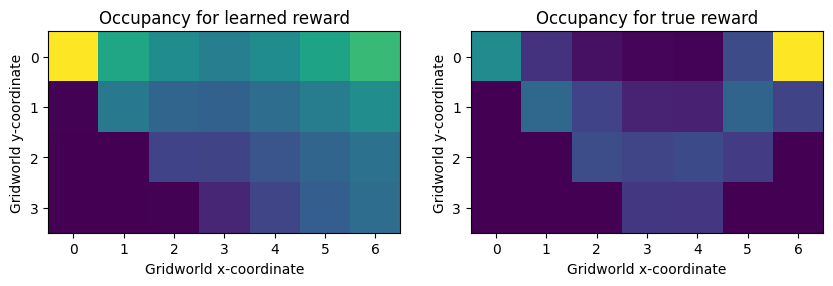

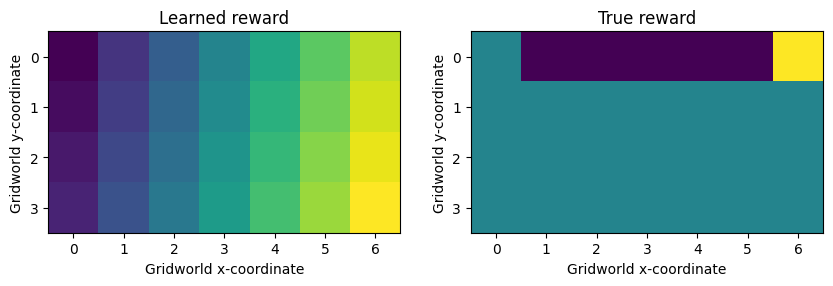

In [5]:
train_mce_irl(om, hidden_sizes=[])

--------------------------
| grad_norm   | 16.5     |
| iteration   | 0        |
| linf_delta  | 2.04     |
| weight_norm | 11.3     |
--------------------------
--------------------------
| grad_norm   | 0.0575   |
| iteration   | 250      |
| linf_delta  | 0.0474   |
| weight_norm | 18       |
--------------------------
--------------------------
| grad_norm   | 0.0536   |
| iteration   | 500      |
| linf_delta  | 0.0189   |
| weight_norm | 20.2     |
--------------------------
--------------------------
| grad_norm   | 0.0194   |
| iteration   | 750      |
| linf_delta  | 0.00852  |
| weight_norm | 22.1     |
--------------------------
Imitation stats:  {'n_traj': 628, 'return_min': -31.0, 'return_mean': 5.850318471337579, 'return_std': 8.464042522467789, 'return_max': 14.0, 'len_min': 8, 'len_mean': 8.0, 'len_std': 0.0, 'len_max': 8}


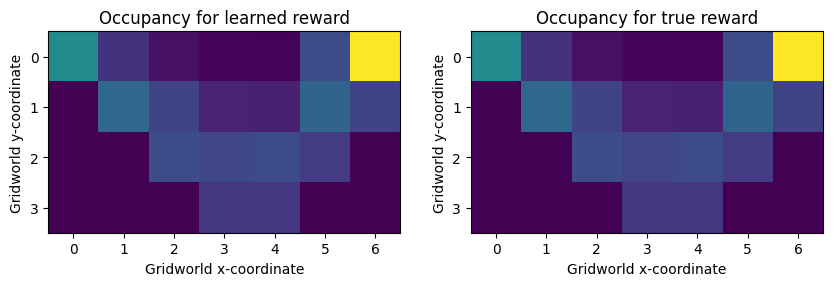

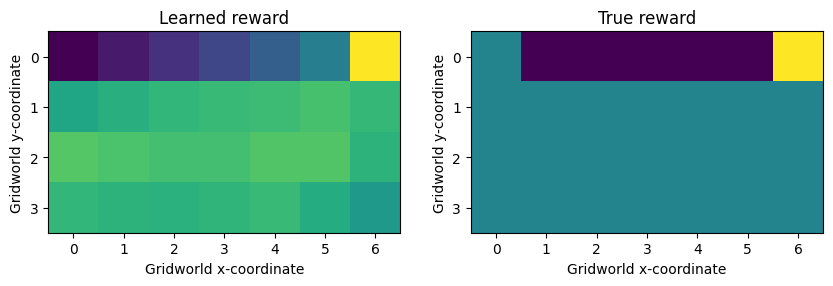

In [6]:
train_mce_irl(om, hidden_sizes=[256])

--------------------------
| grad_norm   | 17.4     |
| iteration   | 0        |
| linf_delta  | 2.58     |
| weight_norm | 11.3     |
--------------------------
--------------------------
| grad_norm   | 4.17     |
| iteration   | 250      |
| linf_delta  | 0.537    |
| weight_norm | 44.3     |
--------------------------
--------------------------
| grad_norm   | 10.7     |
| iteration   | 500      |
| linf_delta  | 0.541    |
| weight_norm | 112      |
--------------------------
--------------------------
| grad_norm   | 18.6     |
| iteration   | 750      |
| linf_delta  | 0.566    |
| weight_norm | 183      |
--------------------------
Imitation stats:  {'n_traj': 628, 'return_min': -31.0, 'return_mean': 5.017515923566879, 'return_std': 8.559719707600031, 'return_max': 14.0, 'len_min': 8, 'len_mean': 8.0, 'len_std': 0.0, 'len_max': 8}


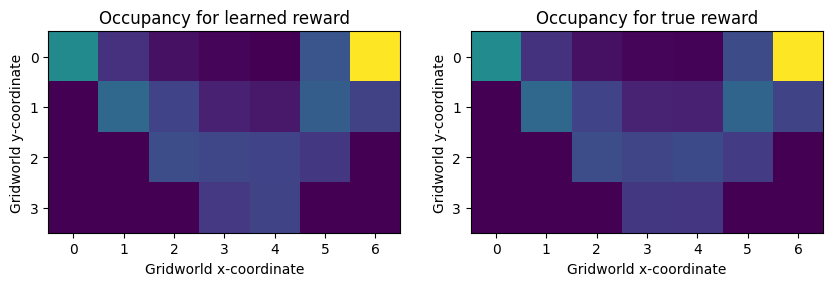

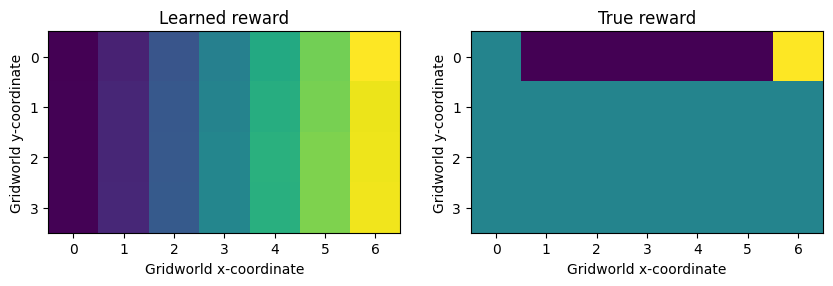

In [7]:
mce_irl_from_trajs = train_mce_irl(expert_trajs[0:10], hidden_sizes=[256])